In [69]:
import os
import zipfile as zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [70]:
import sys

assert 'zipfile'in sys.modules
assert 'pandas'in sys.modules and pd
assert 'numpy'in sys.modules and np
assert 'matplotlib'in sys.modules and plt

## The Data

In this notebook, we will investigate data collected by the Department of Public Health in San Francisco. There are three DataFrames: `bus` which details the information of each restaurant registered with the Department of Public Health, `ins` which lists information about every completed food safety inspection, and `vio` which contains the recordings about food safety violations.



In [71]:
bus = pd.read_csv('businesses.csv',  encoding='ISO-8859-1')
ins = pd.read_csv('inspections.csv',  encoding='ISO-8859-1')
vio = pd.read_csv('violations.csv',  encoding='ISO-8859-1')

In [72]:
display(bus.head())
display(ins.head())
display(vio.head())

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440


,business_id,score,date,type
0,19,94,20160513,routine
1,19,94,20171211,routine
2,24,98,20171101,routine
3,24,98,20161005,routine
4,24,96,20160311,routine


,business_id,date,description
0,19,20171211,Inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensils
2,19,20160513,Unapproved or unmaintained equipment or utensi...
3,19,20160513,Unclean or degraded floors walls or ceilings ...
4,19,20160513,Food safety certificate or food handler card n...


## Examining the Data##


Let's look close at the DataFrames to get a better understanding of the data we are working with.


From its name alone, we expect the `businesses.csv` file to contain information about the restaurants. Let's investigate the granularity of this dataset.

**To start, I'll check to see if any restaurants are listed in the DataFrame more than once.**

In [73]:
def is_all_unique(series):
    if len(series.unique()) == len(series):
        return True
    else:
        return False

is_business_id_unique = is_all_unique(bus['business_id'])
is_business_id_unique

True

**What data types does 'businesses.csv' contain?**

In [74]:
bus.dtypes

business_id       int64
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
phone_number     object
dtype: object

**Here, I'll construct a short summary of each DataFrame.**

In [103]:
bus_summary = pd.DataFrame(**{'columns': ['business_id', 'latitude', 'longitude'],
 'data': {'business_id': {'50%': 68294.5, 'max': 94574.0, 'min': 19.0},
  'latitude': {'50%': 37.780435, 'max': 37.824494, 'min': 37.668824},
  'longitude': {'50%': -122.41885450000001,
   'max': -122.368257,
   'min`': -122.510896}},
 'index': ['min', '50%', 'max']})

ins_summary = pd.DataFrame(**{'columns': ['business_id', 'score'],
 'data': {'business_id': {'50%': 61462.0, 'max': 94231.0, 'min': 19.0},
  'score': {'50%': 92.0, 'max': 100.0, 'min': 48.0}},
 'index': ['min', '50%', 'max']})

vio_summary = pd.DataFrame(**{'columns': ['business_id'],
 'data': {'business_id': {'50%': 62060.0, 'max': 94231.0, 'min': 19.0}},
 'index': ['min', '50%', 'max']})


print('Business Data Summary:')
display(bus_summary)
print('Inspection Data Summary:')
display(ins_summary)
print('Violation Data Summary:')
display(vio_summary)

Business Data Summary:


,business_id,latitude,longitude
min,19.0,37.668824,NaN
50%,68294.5,37.780435,-122.418855
max,94574.0,37.824494,-122.368257


Inspection Data Summary:


,business_id,score
min,19.0,48.0
50%,61462.0,92.0
max,94231.0,100.0


Violation Data Summary:


,business_id
min,19.0
50%,62060.0
max,94231.0


## Zip Codes

Next, let's  explore some of the variables in the business table. We begin by examining the postal code.

Zip codes are qualitative, because their value does not represent a count of something. They are also nominal, because they are used as a "name" or identification, and are not ordered in any specific way in this data set.



**How many restaurants are in each Zip code?**


In [76]:
zip_counts = bus['postal_code'].value_counts()
zip_counts.head()

94110    596
94103    552
94102    462
94107    460
94133    426
Name: postal_code, dtype: int64

**How many businesses have missing Zip codes?**

In [77]:
print('zip_counts describes', sum(zip_counts), 'records.')
print('The original data have', len(bus), 'records')

zip_counts describes 6166 records.
The original data have 6406 records


There are several ways to include missing postal codes in the `zip_counts` series above. One approach is to use the `fillna` method of the series, which will replace all null (a.k.a. NaN) values with a string of our choosing. Below, I picked "?????".

In [78]:
zip_counts = bus.fillna("?????").groupby("postal_code").size().sort_values(ascending=False)
zip_counts.head(15)

postal_code
94110    596
94103    552
94102    462
94107    460
94133    426
94109    380
94111    277
94122    273
94118    249
94115    243
?????    240
94105    232
94108    228
94114    223
94117    204
dtype: int64

An alternate approach is to use the DataFrame `value_counts` method with the optional argument `dropna=False`, which will ensure that null values are counted. In this case, the index will be `NaN` for the row corresponding to a null postal code.

In [79]:
bus["postal_code"].value_counts(dropna=False).sort_values(ascending = False).head(15)

94110    596
94103    552
94102    462
94107    460
94133    426
94109    380
94111    277
94122    273
94118    249
94115    243
NaN      240
94105    232
94108    228
94114    223
94117    204
Name: postal_code, dtype: int64

### Zip Code Lengths

Missing zip codes aren't our only problem. There are also some records where the postal code is wrong, e.g., there are 3 'Ca' and 3 'CA' values. Additionally, there are some extended postal codes that are 9 digits long, rather than the typical 5 digits.

Let's clean up the extended zip codes by dropping the digits beyond the first 5. Rather than deleting or replacing the old values in the `postal_code` column, I'll instead create a new column called `postal_code_5`.

**The reason I'm making a new column is that it's typically good practice to keep the original values when we are manipulating data. This makes it easier to recover from mistakes, and also makes it more clear that we are not working with the original raw data.**

In [81]:
bus['postal_code_5'] = bus['postal_code'].str[:5]
bus.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,postal_code_5
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262,94109
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494,94104
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN,94133
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051,94110
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440,94122


### A Closer Look at Missing Zip Codes

Let's look more closely at records with missing Zip codes. This may help us describe why some records have missing postal codes.  


In [19]:
bus[bus['postal_code'].isnull()]['address'].value_counts().head(3)

 OFF THE GRID                    69
 APPROVED PRIVATE LOCATIONS       6
 APPROVED LOCATIONS               4
Name: address, dtype: int64

Above, we can see that there are a number of restaurants listed as "OFF THE GRID". These listings likely correspond to mobile restaurants, such as trucks and stands. These restaurants do not correspond to a Zip Code, which explains the missing postal codes.

### Incorrect Zip Codes

This dataset is supposed to be only about San Francisco, so let's set up a list of all San Francisco Zip codes.

In [21]:
all_sf_zip_codes = ["94102", "94103", "94104", "94105", "94107", "94108", 
                    "94109", "94110", "94111", "94112", "94114", "94115", 
                    "94116", "94117", "94118", "94119", "94120", "94121", 
                    "94122", "94123", "94124", "94125", "94126", "94127", 
                    "94128", "94129", "94130", "94131", "94132", "94133", 
                    "94134", "94137", "94139", "94140", "94141", "94142", 
                    "94143", "94144", "94145", "94146", "94147", "94151", 
                    "94158", "94159", "94160", "94161", "94163", "94164", 
                    "94172", "94177", "94188"]

We often want to clean the data to improve our analysis. This cleaning might include changing values for a variable or dropping records.


In [82]:
bus[bus['postal_code'] == '94602']

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,postal_code_5
5060,85459,ORBIT ROOM,1900 MARKET ST,San Francisco,CA,94602,NaN,NaN,+14153705584,94602



For example, if we look at this specific observation, we can see the value 94602 is wrong. 94602 is a Zip Code in the east bay.  The most reasonable value, based off an internet search, is 94102. I can modify the `postal_code_5` field using `bus['postal_code_5'].str.replace` to replace 94602.


In [24]:
bus['postal_code_5'].value_counts()['94102']

462

In [83]:
bus['postal_code_5'] = bus['postal_code_5'].str.replace('94602', '94102')

Now that we have corrected one of the postal codes, let's filter our `bus` data such that only postal codes from San Francisco remain. While we're at it, we'll also remove the businesses that are missing a postal code.

In [84]:
bus = bus[bus['postal_code'].isin(all_sf_zip_codes)]
bus.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,postal_code_5
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262,94109
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494,94104
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN,94133
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051,94110
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440,94122


## Latitude and Longitude

Let's also consider latitude and longitude values in the `bus` data frame and get a sense of how many are missing.

### Missing Longitude Values

How many businesses are missing longitude values?

In [85]:
num_missing_longs = len(bus[bus['longitude'].isnull()==True])
num_missing_longs

2940

Let's try to identify which ZIP codes are missing the most longitude values. Let's focus on only the "dense" ZIP codes of the city of San Francisco, listed below as `sf_dense_zip`.

In [86]:
sf_dense_zip = ["94102", "94103", "94104", "94105", "94107", "94108",
                "94109", "94110", "94111", "94112", "94114", "94115",
                "94116", "94117", "94118", "94121", "94122", "94123", 
                "94124", "94127", "94131", "94132", "94133", "94134"]

**In the cell below, I'll create a few functions that will help us identify some characteristics about missing data in each Zip Code.**

In [29]:
def num_null(series):
    return len(series[series.isnull()])
def num_not_null(series):
    return len(series[~series.isnull()])
def frac_null(series):
    return len(series[series.isnull()]) / len(series)
bus_sf = bus[bus['postal_code'].isin(sf_dense_zip)]


num_missing_in_each_zip = bus_sf['longitude'].groupby(bus_sf['postal_code_5']).agg(num_null).sort_values(ascending=False)
num_missing_in_each_zip.head()

postal_code_5
94110    294.0
94103    284.0
94107    275.0
94102    221.0
94109    171.0
Name: longitude, dtype: float64

**Let's now count the proportion of null values of longitudinal coordinates.**

In [87]:
fraction_missing_df = num_missing_in_each_zip = bus_sf['longitude'].groupby(bus_sf['postal_code_5']).agg([num_null,num_not_null,frac_null])
fraction_missing_df = fraction_missing_df.sort_values('frac_null', ascending=False)
new_names = {'num_null':'count null', 'num_not_null':'count non null', 'frac_null': 'fraction null'}
fraction_missing_df = fraction_missing_df.rename(columns = new_names) 
fraction_missing_df.head()


,count null,count non null,fraction null
postal_code_5,,,
94124,118.0,73.0,0.617801
94107,275.0,185.0,0.597826
94104,79.0,60.0,0.568345
94105,127.0,105.0,0.547414
94132,71.0,62.0,0.533835


## Summary of the Business Data

Before we move on to explore the other data, let's take stock of what we have learned and the implications of our findings on future analysis. 

* We found that the business ID is unique across records and so we may be able to use it as a key in joining tables. 
* We found that there are some errors with the ZIP codes. As a result, we dropped the records with ZIP codes outside of San Francisco or ones that were missing. In practice, however, we could take the time to look up the restaurant address online and fix these errors.   
* We found that there are a huge number of missing longitude (and latitude) values. Fixing would require a lot of work, but could in principle be automated for records with well-formed addresses. 

## Investigating the Inspection Data

Let's now turn to the inspection DataFrame. Earlier, we found that `ins` has 4 columns named `business_id`, `score`, `date` and `type`.  In this section, we determine the granularity of `ins` and investigate the kinds of information provided for the inspections. 

In [31]:
ins.head(5)

,business_id,score,date,type
0,19,94,20160513,routine
1,19,94,20171211,routine
2,24,98,20171101,routine
3,24,98,20161005,routine
4,24,96,20160311,routine


From calling `head`, we know that each row in this table corresponds to a single inspection. Let's get a sense of the total number of inspections conducted, as well as the total number of unique businesses that occur in the dataset.

In [88]:
# The number of rows in ins
rows_in_table  = len(ins)

# The number of unique business IDs in ins.
unique_ins_ids = ins['business_id'].nunique()
print('The number of rows in ins: ', rows_in_table)
print('The number of unique business IDs in ins:', unique_ins_ids)

The number of rows in ins:  14222
The number of unique business IDs in ins: 5766




Now, let's try to figure out what years the data span. The dates in our file are formatted as strings such as `20160503`, which are a little tricky to interpret. The ideal solution for this problem is to modify our dates so that they are in an appropriate format for analysis. 

In the cell below, I add a new column to `ins` called `new_date` which contains the `date` stored as a datetime object. This calls the `pd.to_datetime` method, which converts a series of string representations of dates (and/or times) to a series containing a datetime object.

In [89]:
ins['new_date'] = pd.to_datetime(ins['date'], format='%Y%m%d')
ins.head(5)

,business_id,score,date,type,new_date
0,19,94,20160513,routine,2016-05-13
1,19,94,20171211,routine,2017-12-11
2,24,98,20171101,routine,2017-11-01
3,24,98,20161005,routine,2016-10-05
4,24,96,20160311,routine,2016-03-11


This is still not ideal for our analysis, so we'll add one more column that is just equal to the year by using the `dt.year` property of the new series we just created.

In [90]:
ins['year'] = ins['new_date'].dt.year
ins.head(5)

,business_id,score,date,type,new_date,year
0,19,94,20160513,routine,2016-05-13,2016
1,19,94,20171211,routine,2017-12-11,2017
2,24,98,20171101,routine,2017-11-01,2017
3,24,98,20161005,routine,2016-10-05,2016
4,24,96,20160311,routine,2016-03-11,2016


In [92]:
ins.groupby('year').count()

,business_id,score,date,type,new_date
year,,,,,
2015,3305,3305,3305,3305,3305
2016,5443,5443,5443,5443,5443
2017,5166,5166,5166,5166,5166
2018,308,308,308,308,308


Now that we have this handy `year` column, we can try to understand our data better.

This data set covers the years 2015 - 2018. There are about 3/5ths as much entries for 2015 than 2016 and 2017, and a sharp drop off in entries in 2018, only about 10% of the number of entries in 2015 and 5% of the number of entries in 2017 and 2018

## Exploring Inspection Scores

Let's look at the distribution of inspection scores. As we saw before when we called `head` on this data frame, inspection scores appear to be integer values. The discreteness of this variable means that we can use a barplot to visualize the distribution of the inspection score. 

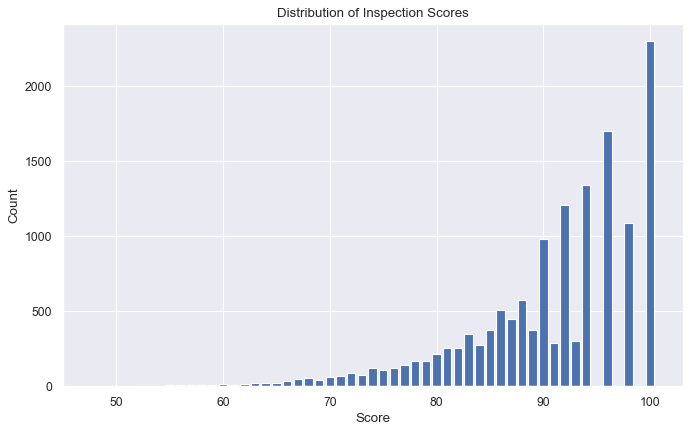

In [93]:
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x= ins['score'].sort_values().unique(), height=ins.groupby('score').count()['business_id'])
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Inspection Scores');

100 is the most common score, so plenty of restaurants get 100% on their inspection. There are very few scores below 60, which indicates a low usages of the lower end of the scoring scale. It also seems as though most of the higher end scores are more uniform, and take on a smaller set of values than the scores below 90. 

### The Bottom of the Barrel

Let's figure out which restaurant had the worst score in the DataFrame (single lowest score). Let's start by creating a new dataframe called `ins_named`. It's exactly the same as `ins`, except that it does not have the name and address of every business, as determined by the `bus` dataframe. If a `business_id` in `ins` does not exist in `bus`, the name and address should be given as NaN.



For quick reference, a pandas 'left' join keeps the keys from the left frame, so if ins is the left frame, all the keys from ins are kept and if a set of these keys don't have matches in the other frame, the columns from the other frame for these "unmatched" key rows contains NaNs.

See the official [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) on how to use `merge`.

In [50]:
ins_named = pd.merge(ins, bus[['business_id','name','address']], how='left', on='business_id')
ins_named.head(20)

,business_id,score,date,type,new_date,year,name,address
0,19,94,20160513,routine,2016-05-13,2016,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR"
1,19,94,20171211,routine,2017-12-11,2017,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR"
2,24,98,20171101,routine,2017-11-01,2017,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR"
3,24,98,20161005,routine,2016-10-05,2016,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR"
4,24,96,20160311,routine,2016-03-11,2016,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR"
5,31,98,20151204,routine,2015-12-04,2015,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST
6,45,78,20160104,routine,2016-01-04,2016,CHARLIE'S DELI CAFE,3202 FOLSOM ST
7,45,88,20170307,routine,2017-03-07,2017,CHARLIE'S DELI CAFE,3202 FOLSOM ST
8,45,85,20170914,routine,2017-09-14,2017,CHARLIE'S DELI CAFE,3202 FOLSOM ST
9,45,84,20160614,routine,2016-06-14,2016,CHARLIE'S DELI CAFE,3202 FOLSOM ST


In [100]:
minimum = ins_named['score'].min()
display('The restaurant with the lowest inpection score is ', ins_named[ins_named['score']==minimum]['name'].astype('str'))

'The restaurant with the lowest inpection score is '

13179    DA CAFE
Name: name, dtype: object

### Extreme Improvements

Let's see which restaurant has had the most extreme improvement in its rating, AKA scores. Let the "swing" of a restaurant be defined as the difference between its highest-ever and lowest-ever rating. **I'm only going to consider restaurants with at least 3 ratings, AKA rated for at least 3 times (3 scores).** 

In [52]:
three_plus = ins_named.groupby('name').filter(lambda x: x['business_id'].count() >= 3).sort_values('name')
gb_max = three_plus.groupby('name').max()
gb_min = three_plus.groupby('name').min()



max_swing = gb_max['score'].subtract(gb_min['score']).sort_values(ascending=False).index[0]
max_swing

"JOANIE'S DINER INC."

### Successive Inspections

To get a sense of the number of times each restaurant has been inspected, let's create a multi-indexed dataframe called `inspections_by_id_and_year` where each row corresponds to data about a given business in a single year, and there is a single data column named `count` that represents the number of inspections for that business in that year.

In [53]:
inspections_by_id_and_year = ins_named.groupby(['business_id','year']).count().drop(columns=['date','type','new_date','name','address']).rename(columns={'score':'count'})
inspections_by_id_and_year.head()

count
business_id year       
19          2016      1
            2017      1
24          2016      2
            2017      1
31          2015      1

You should see that some businesses are inspected many times in a single year. Let's get a sense of the distribution of the counts of the number of inspections by calling `value_counts`. There are quite a lot of businesses with 2 inspections in the same year, so it seems like it might be interesting to see what we can learn from such businesses.

In [56]:
display(inspections_by_id_and_year['count'].value_counts())

1    9531
2    2175
3     111
4       2
Name: count, dtype: int64

What's the relationship between the first and second scores for the businesses with 2 inspections in a year? Do they typically improve? For simplicity, let's focus on only 2016 for this problem, using `ins2016` data frame that will be created below. 

First, I'll make a dataframe called `scores_pairs_by_business` indexed by `business_id` (containing only businesses with exactly 2 inspections in 2016).  This dataframe contains the field `score_pair` consisting of the score pairs **ordered chronologically**  `[first_score, second_score]`. 

Then, I will plot these scores. That is, make a scatter plot to display these pairs of scores.


In [101]:
ins2016 = ins[ins['year'] == 2016]
twos = ins2016.groupby('business_id').count()
twos = twos[twos['score']==2]
twos = ins2016[ins2016['business_id'].isin(twos.index)].sort_values('date').rename(columns={'score':'score_pair'})
twos = twos.groupby('business_id')['score_pair'].apply(list)

scores_pairs_by_business = pd.DataFrame(twos)
scores_pairs_by_business

,score_pair
business_id,
24,"[96, 98]"
45,"[78, 84]"
66,"[98, 100]"
67,"[87, 94]"
76,"[100, 98]"
...,...
87761,"[86, 92]"
87802,"[91, 98]"
88323,"[75, 75]"


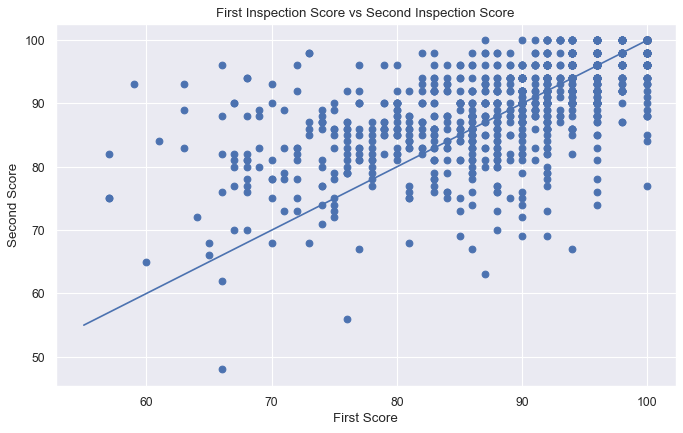

In [102]:
first, second = zip(*scores_pairs_by_business['score_pair'])
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(first, second)
plt.plot([55,100], [55,100])
plt.xlabel('First Score')
plt.ylabel('Second Score')
plt.axis(xlim=(55, 100), ylim=(55, 100))
plt.title('First Inspection Score vs Second Inspection Score');

Another way to compare the scores from the two inspections is to examine the difference in scores. Subtract the first score from the second in `scores_pairs_by_business`. Make a histogram of these differences in the scores. We might expect these differences to be positive, indicating an improvement from the first to the second inspection.


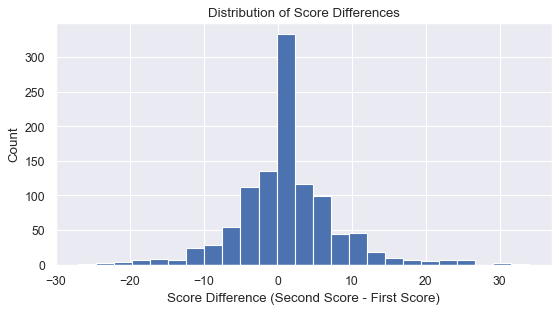

In [108]:
plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
plt.hist(np.array(second) - np.array(first), bins = 25)
plt.xlabel('Score Difference (Second Score - First Score)')
plt.ylabel('Count')

plt.title('Distribution of Score Differences');

**If a retaurant's score improves from the first score to the second score, their entry would appear above the x=y line on the scatter plot. A majority of restaurants are above this line.**

**If a retaurant's score improves from the first score to the second score, their entry appears on the right half of the histogram.**

## Summary of the Inspections Data

What we have learned about the inspections data? What might be some next steps in our investigation? 

* We found that the records are at the inspection level and that we have inspections for multiple years.   
* We also found that many restaurants have more than one inspection a year. 
* By joining the business and inspection data, we identified the name of the restaurant with the worst rating and optionally the names of the restaurants with the best rating.
* We identified the restaurant that had the largest swing in rating over time.
* We also examined the relationship between the scores when a restaurant has multiple inspections in a year.  